# Load modules

In [2]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

from collections import namedtuple

from pa_lib.file import (
    store_bin,
    project_dir,
    data_files,
    load_csv,
    load_bin,
    write_xlsx,
    load_txt
)

from pa_lib.data import (
    as_dtype,
    dtFactor,
    desc_col,
    lookup,
    clean_up_categoricals
)

from pa_lib.util import (
    collect,
    value,
    flatten,
    normalize_rows,
    list_items
)

from pa_lib.log import time_log
from pa_lib.types import Record

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

In [143]:
from pa_lib.util import iso_to_datetime

In [127]:
from pa_lib.data  import calc_col_partitioned

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# Load data files

In [125]:
with project_dir("MediaFocus"):
    # List files in folder:
    display(data_files("*.feather"))
    
    # Branchen per KW über sie letzten 10 Jahre:
    br_kw     = load_bin("branchen_kw_10y.feather").astype({'Jahr': 'int64'})
    
    # Branchen und Produktgruppen letzten 10 Jahre:
    br_pg_kw  = load_bin("branchen_pg_kw_10y.feather")
    
    # Branchen und Werbetreibende (aehnlich zu Endkunde) letzten 10 Jahre
    br_wbt_kw = load_bin("branchen_wbt_kw.feather")

,size,mtime
name,,
branchen_kw_10y.feather,100.9 KB,31.10.19 15:28:44
branchen_pg_kw_10y.feather,553.2 KB,31.10.19 15:28:44
branchen_wbt_kw.feather,15.2 MB,31.10.19 15:28:44


18:17:15 [INFO] Started loading binary file ...
18:17:15 [INFO] Reading from file C:\Users\stc\data\MediaFocus\branchen_kw_10y.feather
18:17:15 [INFO] ... finished loading binary file in 0.0s (0.02s CPU)
18:17:15 [INFO] Started loading binary file ...
18:17:15 [INFO] Reading from file C:\Users\stc\data\MediaFocus\branchen_pg_kw_10y.feather
18:17:15 [INFO] ... finished loading binary file in 0.0s (0.0s CPU)
18:17:15 [INFO] Started loading binary file ...
18:17:15 [INFO] Reading from file C:\Users\stc\data\MediaFocus\branchen_wbt_kw.feather
18:17:15 [INFO] ... finished loading binary file in 0.01s (0.02s CPU)


In [126]:
print(80*"#"+"\n")
print("br_kw")
display(br_kw.shape)
display(
    br_kw.sample(5)
)


print(80*"#"+"\n")
print("br_pg_kw")
display(br_pg_kw.shape)
display(
    br_pg_kw.sample(5)
)


print(80*"#"+"\n")
print("br_wbt_kw")
display()
display(
    br_wbt_kw.sample(5)
)
print(80*"#")

################################################################################

br_kw


(231, 55)

,Jahr,Branche,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53
203,2018,PERSOENLICHER BEDARF,834341,1918943,1415895,1724819,1498080,1055181,800367,1193182,2780822,2443971,3599982,3566419,2758233,1036234,1241536,1793820,2320453,2365624,1962659,1247582,1761562,1334536,1056729,902767,1087966,1044392,811816,758493,877832,1014842,678977,645849,816683,949229,1463155,3174198,2707110,1719968,2309508,2208324,1827183,1711117,3740299,4335818,3585349,4572376,3880315,3655015,3317138,2385243,1766695,707353,0
50,2011,GETRAENKE,1492814,1552610,1022287,1814449,1657064,1835040,1537926,2010181,2368115,2096793,2398589,2386686,1936547,3445049,3341028,2870863,4290703,4111148,4286442,4301970,6253078,4694567,3688446,2934707,3511083,3852953,2879267,2271132,2732059,2502785,3263713,2342621,4504837,5237343,4673899,3059381,2621109,2861102,4235588,2889577,2098041,2189634,3203294,2722577,3138366,2560831,4312177,5551205,4144809,4296281,2791709,3385608,0
84,2013,"BAUEN, INDUSTRIE, EINRICHTUNG",5244307,4237752,3370243,4608626,3975047,3553100,4204997,5760871,5570359,7412446,8756213,6685389,7030363,6303697,7786618,7882594,6641468,6823232,6029367,5638414,4700178,5469806,4095989,5429349,4553044,6318898,3118392,2853106,3177719,3083639,3031393,2396770,4476162,3440594,5817103,4592318,6278150,6431860,8562065,7950569,7069054,5759421,8527502,7304756,6948119,5861609,4897884,5765279,4789327,5155697,3870875,5277003,0
91,2013,"FREIZEIT, GASTRONOMIE, TOURISMUS",5297066,6375876,6878781,6900236,6168101,4925531,4374742,4867482,6385472,4989153,5515629,6457697,4851819,5749404,4927834,4816293,5598244,5873078,4190191,5290647,4701207,5629224,5180770,4936110,6040585,5537945,4223752,2598033,3872796,4106402,3771421,3105228,3940259,4241967,7145438,5513021,4930479,4610714,4771311,5321088,3989047,4060604,5742348,6246579,3920851,4833098,4803462,6235603,5703418,4675652,3635942,3671105,0
82,2012,VERANSTALTUNGEN,2876702,4245533,4259739,3738502,4335515,3904863,3775183,4373062,6135824,5995394,5682534,5774702,5984324,5485419,4742981,6336989,6631870,6981104,5387801,5228229,5876604,6086912,5637417,5464973,5351298,5692339,5112925,4560181,3612287,3506196,3623054,3817870,5149911,5753931,7101511,5853753,5740617,6167375,6273513,6362977,4878454,5523269,6983001,6996224,6843976,5431854,6112660,8284383,6405954,5665246,4528028,2704417,0


################################################################################

br_pg_kw


(1309, 56)

,Jahr,Branche,Produktgruppe,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53
1029,2017,NAHRUNGSMITTEL,BAECKEREI,157360,13842,85571,92191,159254,190828,136308,654974,746483,333801,789309,310906,135511,89057,29427,66143,133545,183401,187069,163435,333818,82496,166097,26498,70780,170468,66783,9645,57842,117176,0,206618,210880,275614,337312,457761,976828,1301652,1552283,554395,203972,313057,154827,314068,173681,390641,447661,530140,286034,368026,33280,42407,0
853,2016,DIGITAL + HAUSHALT,HAUSHALTSGERAETE,838146,999788,719540,678698,969411,805369,1501408,939852,1782422,2277880,945639,1419435,1714669,1762373,1165917,1185283,1419637,1557599,1266073,669500,1190813,690060,1177785,1035663,620337,673458,880100,616367,578172,439879,381500,308784,432234,608122,1553874,1850555,1119315,2125177,1988621,1187684,1525727,1519101,1860891,1914491,1096628,766083,2349878,3892566,2914022,2151600,1401958,454351,254204
388,2012,FAHRZEUGE,PKW (GEBRAUCHT),14116,407762,312615,130106,29328,148875,194882,49552,26479,61876,69555,120331,44577,49542,20249,46539,8887,97589,110786,50846,30652,30393,7123,21685,14891,28222,11880,30539,20132,18284,9199,7783,7852,31809,8097,20916,15664,75184,42675,51116,6971,25113,5944,35315,15826,58757,41315,48156,15751,21700,28581,10080,0
1235,2019,GETRAENKE,"KAFFEE, TEE, KAKAO",146702,90728,656398,196840,722831,375820,803620,237634,588593,651447,810013,1178971,1050359,988945,528313,206278,668419,356039,979571,1326506,984427,881392,521887,350082,625776,883170,633783,236335,364704,484654,520961,467032,271833,323559,1103084,1192101,894932,748300,793200,186695,0,0,0,0,0,0,0,0,0,0,0,0,0
82,2009,NAHRUNGSMITTEL,SCHOKOLADE + SUESSWAREN,90929,218236,541007,821487,1793922,1552233,1757984,1133336,1806488,1409032,922104,1103336,1904998,2312879,1467596,1266639,985139,2032213,1567858,835645,868609,447676,1645972,658512,1081795,725623,663810,104999,323438,322829,60976,251724,409395,620245,980085,1348213,1127888,1118974,1557989,2242319,2069406,2774953,2278143,3970095,3365763,2388831,2461290,2954114,3082767,4035352,2970423,1243196,170955


################################################################################

br_wbt_kw


(35471, 55)

,Branche,Werbungtreibender,KW_01,KW_02,KW_03,KW_04,KW_05,KW_06,KW_07,KW_08,KW_09,KW_10,KW_11,KW_12,KW_13,KW_14,KW_15,KW_16,KW_17,KW_18,KW_19,KW_20,KW_21,KW_22,KW_23,KW_24,KW_25,KW_26,KW_27,KW_28,KW_29,KW_30,KW_31,KW_32,KW_33,KW_34,KW_35,KW_36,KW_37,KW_38,KW_39,KW_40,KW_41,KW_42,KW_43,KW_44,KW_45,KW_46,KW_47,KW_48,KW_49,KW_50,KW_51,KW_52,KW_53
25705,INITIATIVEN + KAMPAGNEN,LAUSANNE REGION,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6584,4364,10695,2313,0,0,3841,0,0,0,0,0,0
17812,FAHRZEUGE,CAMADA CICLI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,990,990,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27682,MEDIEN,ABZ VERLAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,660,0,0,0,0,0,0,0,0,0,0
13516,DIENSTLEISTUNG,QS QUACQUARELLI SYMONDS,0,0,0,0,4000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3968,0,0,0,0,0,0,0,0,0,0,0,0,0
11255,DIENSTLEISTUNG,HAYS SCHWEIZ AG,0,0,0,0,0,0,0,0,0,3900,5096,25004,0,0,9700,10278,0,5328,5096,3900,0,0,4950,5800,0,0,0,3900,0,0,0,0,5096,0,5800,4950,0,0,0,3900,5096,0,5328,5328,4950,0,0,0,6164,5800,0,0,0


################################################################################


# Data Prep

In [200]:
## Jahres Brutto
kw_columns = list(br_kw.columns)[2:]
br_kw.loc[:,"Brutto_Jahr"] = br_kw.loc[:,kw_columns].sum(axis="columns")

################################################################################
## Relatives Jahres-Brutto

br_kw = calc_col_partitioned(
    df=br_kw,
    col="Brutto_Jahr_Relativ", # Name new column
    #fun="max",
    fun=lambda s: (s / s.max()),
    on="Brutto_Jahr",
    part_by="Branche")

################################################################################
display(
    br_kw
        .loc[:,["Jahr","Branche","Brutto_Jahr","Brutto_Jahr_Relativ"]]
        .sample(5)
)


,Jahr,Branche,Brutto_Jahr,Brutto_Jahr_Relativ
44,2011,DIENSTLEISTUNG,6.533237e+08,0.778371
27,2010,FINANZEN,9.090460e+08,0.857663
170,2017,DIENSTLEISTUNG,7.664536e+08,0.913155
140,2015,PERSOENLICHER BEDARF,3.405993e+08,0.933461
57,2011,PHARMA + GESUNDHEIT,4.518754e+08,0.774264


## Melting `br_kw`

In [203]:
################################################################################
## Put all KW_XY folders underneath each other:

calender_columns = [col for col in br_kw.columns if col.startswith("KW_")]

container_df = (
    pd.melt(
        br_kw,
        id_vars    = ["Branche","Jahr"],
        value_vars = calender_columns,
        var_name   = "KW",
        value_name = "Brutto"
    )
)

################################################################################
## Create Datum column:

years_temp = container_df.loc[:,"Jahr"]
kws_temp   = container_df.loc[:,"KW"].map(lambda x : int(x[3:5]))

date_series = (
    years_temp
        .combine(
            kws_temp,
            func = lambda year, kw: iso_to_datetime(year=year, kw=kw, day=1)
        )
)

container_df.loc[:,"Datum"] = date_series

br_kw_datum = (
    container_df
        #.loc[:,["Branche","Datum","Brutto"]]
        .sort_values(["Branche","Datum"])
)
################################################################################
## Turn Datum column into Integer, so lmplot can handle it:

kw_to_decimal = br_kw_datum.KW.map(lambda x : int(x[3:5]))/53
Datum_Rel = (br_kw_datum.Jahr + kw_to_decimal )

br_kw_datum.loc[:,"Datum_Relativ"] = Datum_Rel # integer series

################################################################################
## Create Brutto relative to min and max of Branche:

br_kw_datum = calc_col_partitioned(
    df      = br_kw_datum,
    col     = "Brutto_Relativ",
    fun     = lambda s: (s  / s.max()),
    on      = "Brutto",
    part_by = "Branche")

################################################################################
## Show me the result:

display(br_kw_datum.head())

,Branche,Jahr,KW,Brutto,Datum,Datum_Relativ,Brutto_Relativ
0,"BAUEN, INDUSTRIE, EINRICHTUNG",2009,KW_01,1475891,2008-12-29,2009.018868,0.152056
231,"BAUEN, INDUSTRIE, EINRICHTUNG",2009,KW_02,2919457,2009-01-05,2009.037736,0.300782
462,"BAUEN, INDUSTRIE, EINRICHTUNG",2009,KW_03,2920115,2009-01-12,2009.056604,0.300850
693,"BAUEN, INDUSTRIE, EINRICHTUNG",2009,KW_04,3320761,2009-01-19,2009.075472,0.342127
924,"BAUEN, INDUSTRIE, EINRICHTUNG",2009,KW_05,3561250,2009-01-26,2009.094340,0.366904


# Find patterns

## `br_kw`

In [192]:
branchen_liste = list(set(br_kw.loc[:,"Branche"]))
#branchen_liste

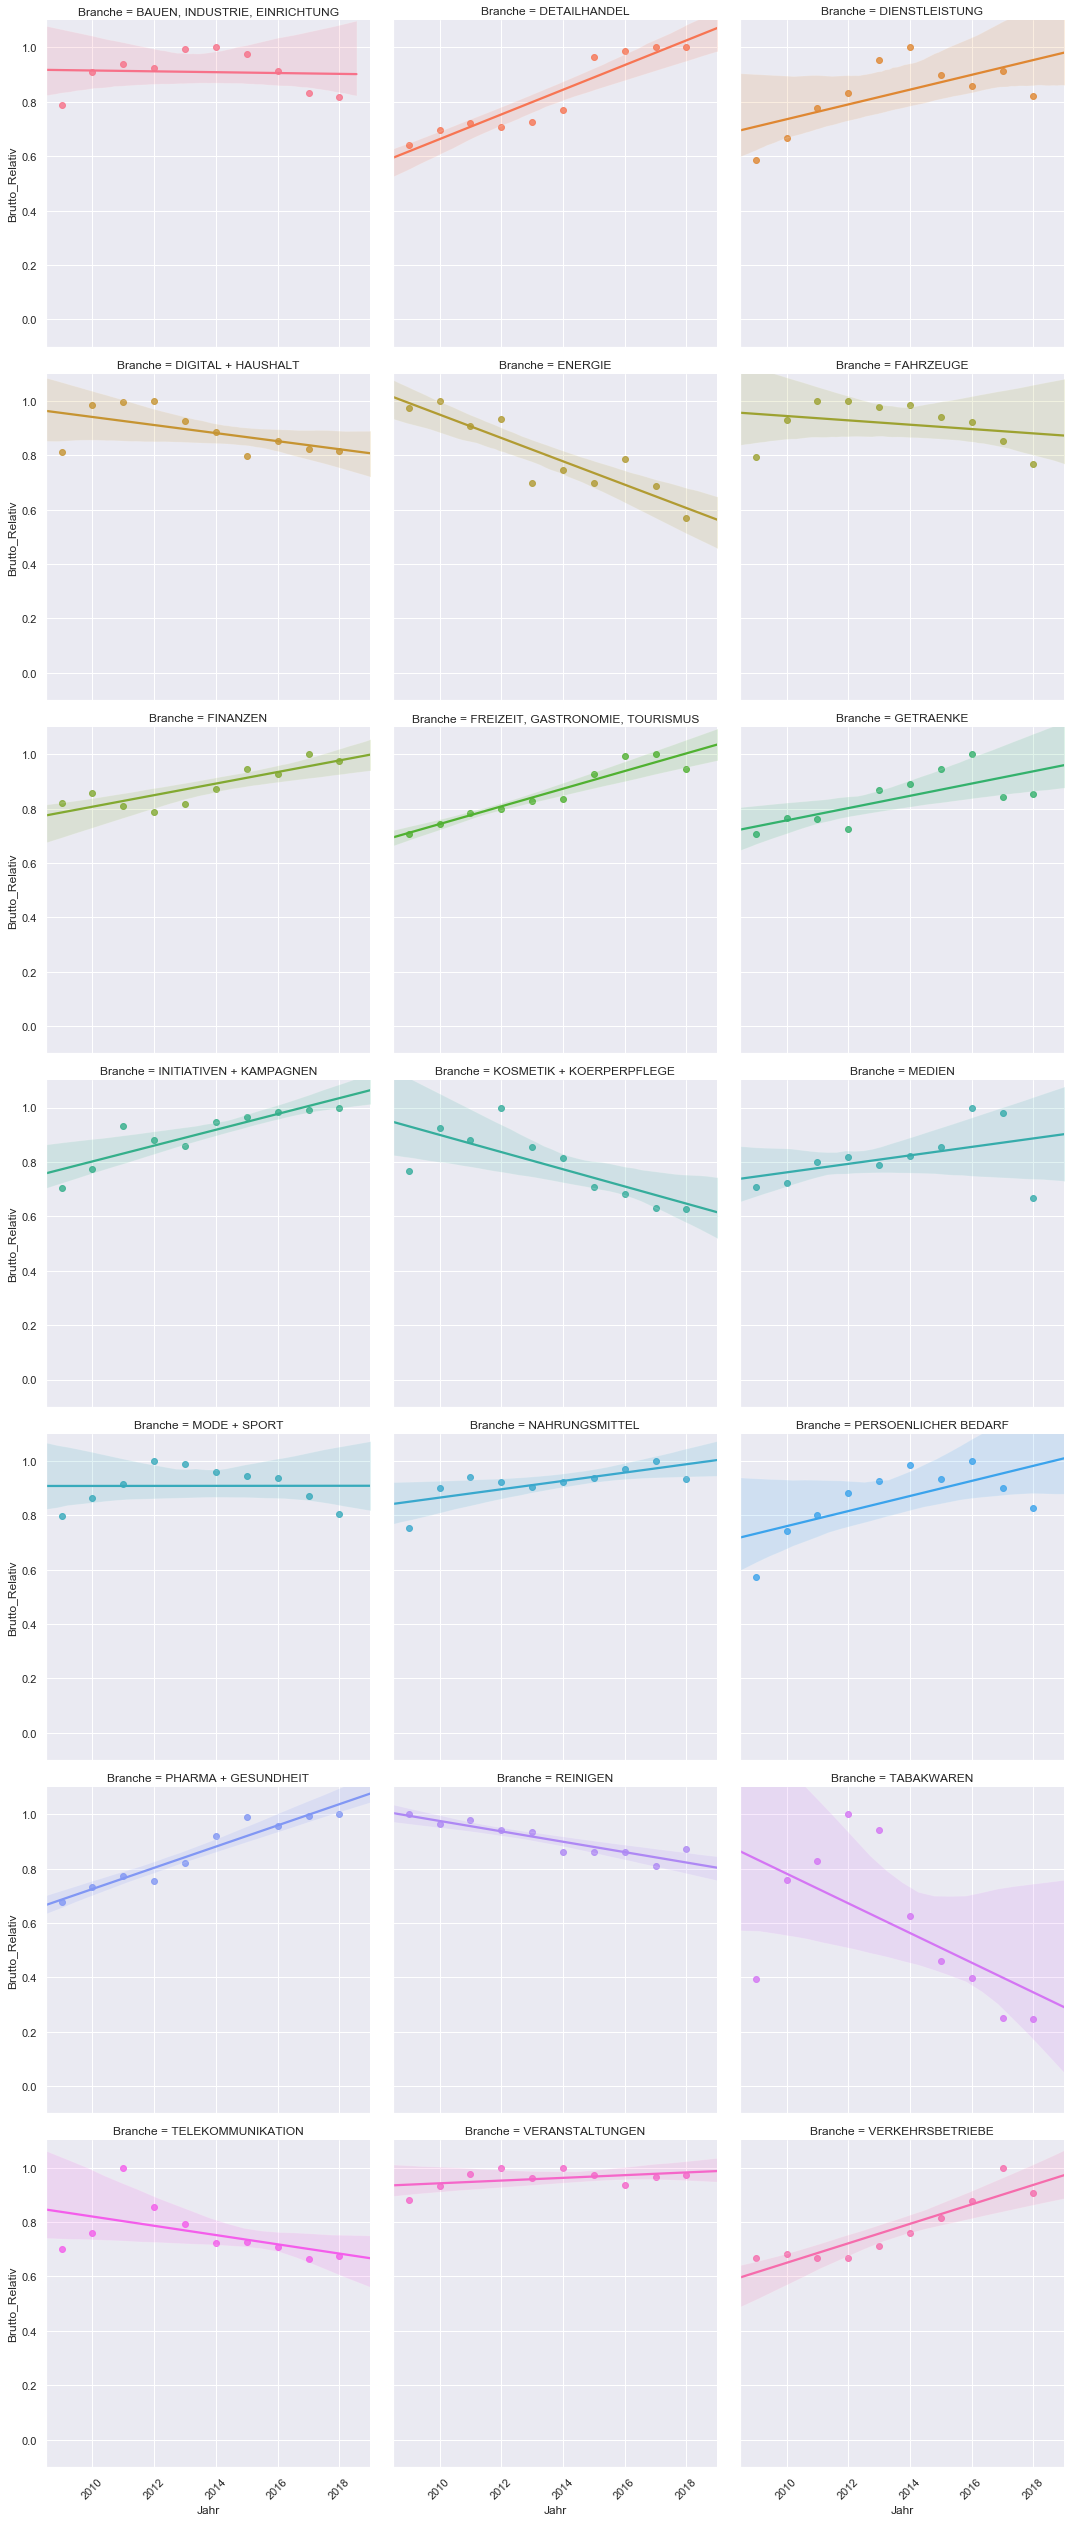

In [202]:
## Remove 2019, because it's still not finished:

row_without_2019 = (br_kw.loc[:,"Jahr"] < 2019)

################################################################################
## Create facet grid with regression and confidence interval:

g = sns.lmplot(
    x        = "Jahr",
    y        = "Brutto_Relativ",
    col      = "Branche",
    hue      = "Branche", # kinda useless, but nice to look at!
    data     = br_kw.loc[row_without_2019,:],
    col_wrap = 3, # How many plots per row
    height   = 5,
    order    = 1, # polynomial regression of order, best for 1 or 2
    #lowess = True,
    #ci       = 95,
).set(xlim=(2008.5, 2019),ylim=(-0.1,1.1))

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

################################################################################
## Cleanup

del row_without_2019

***
> 1. Not enough data points. Granularity is too low.
***

## `br_kw_datum`

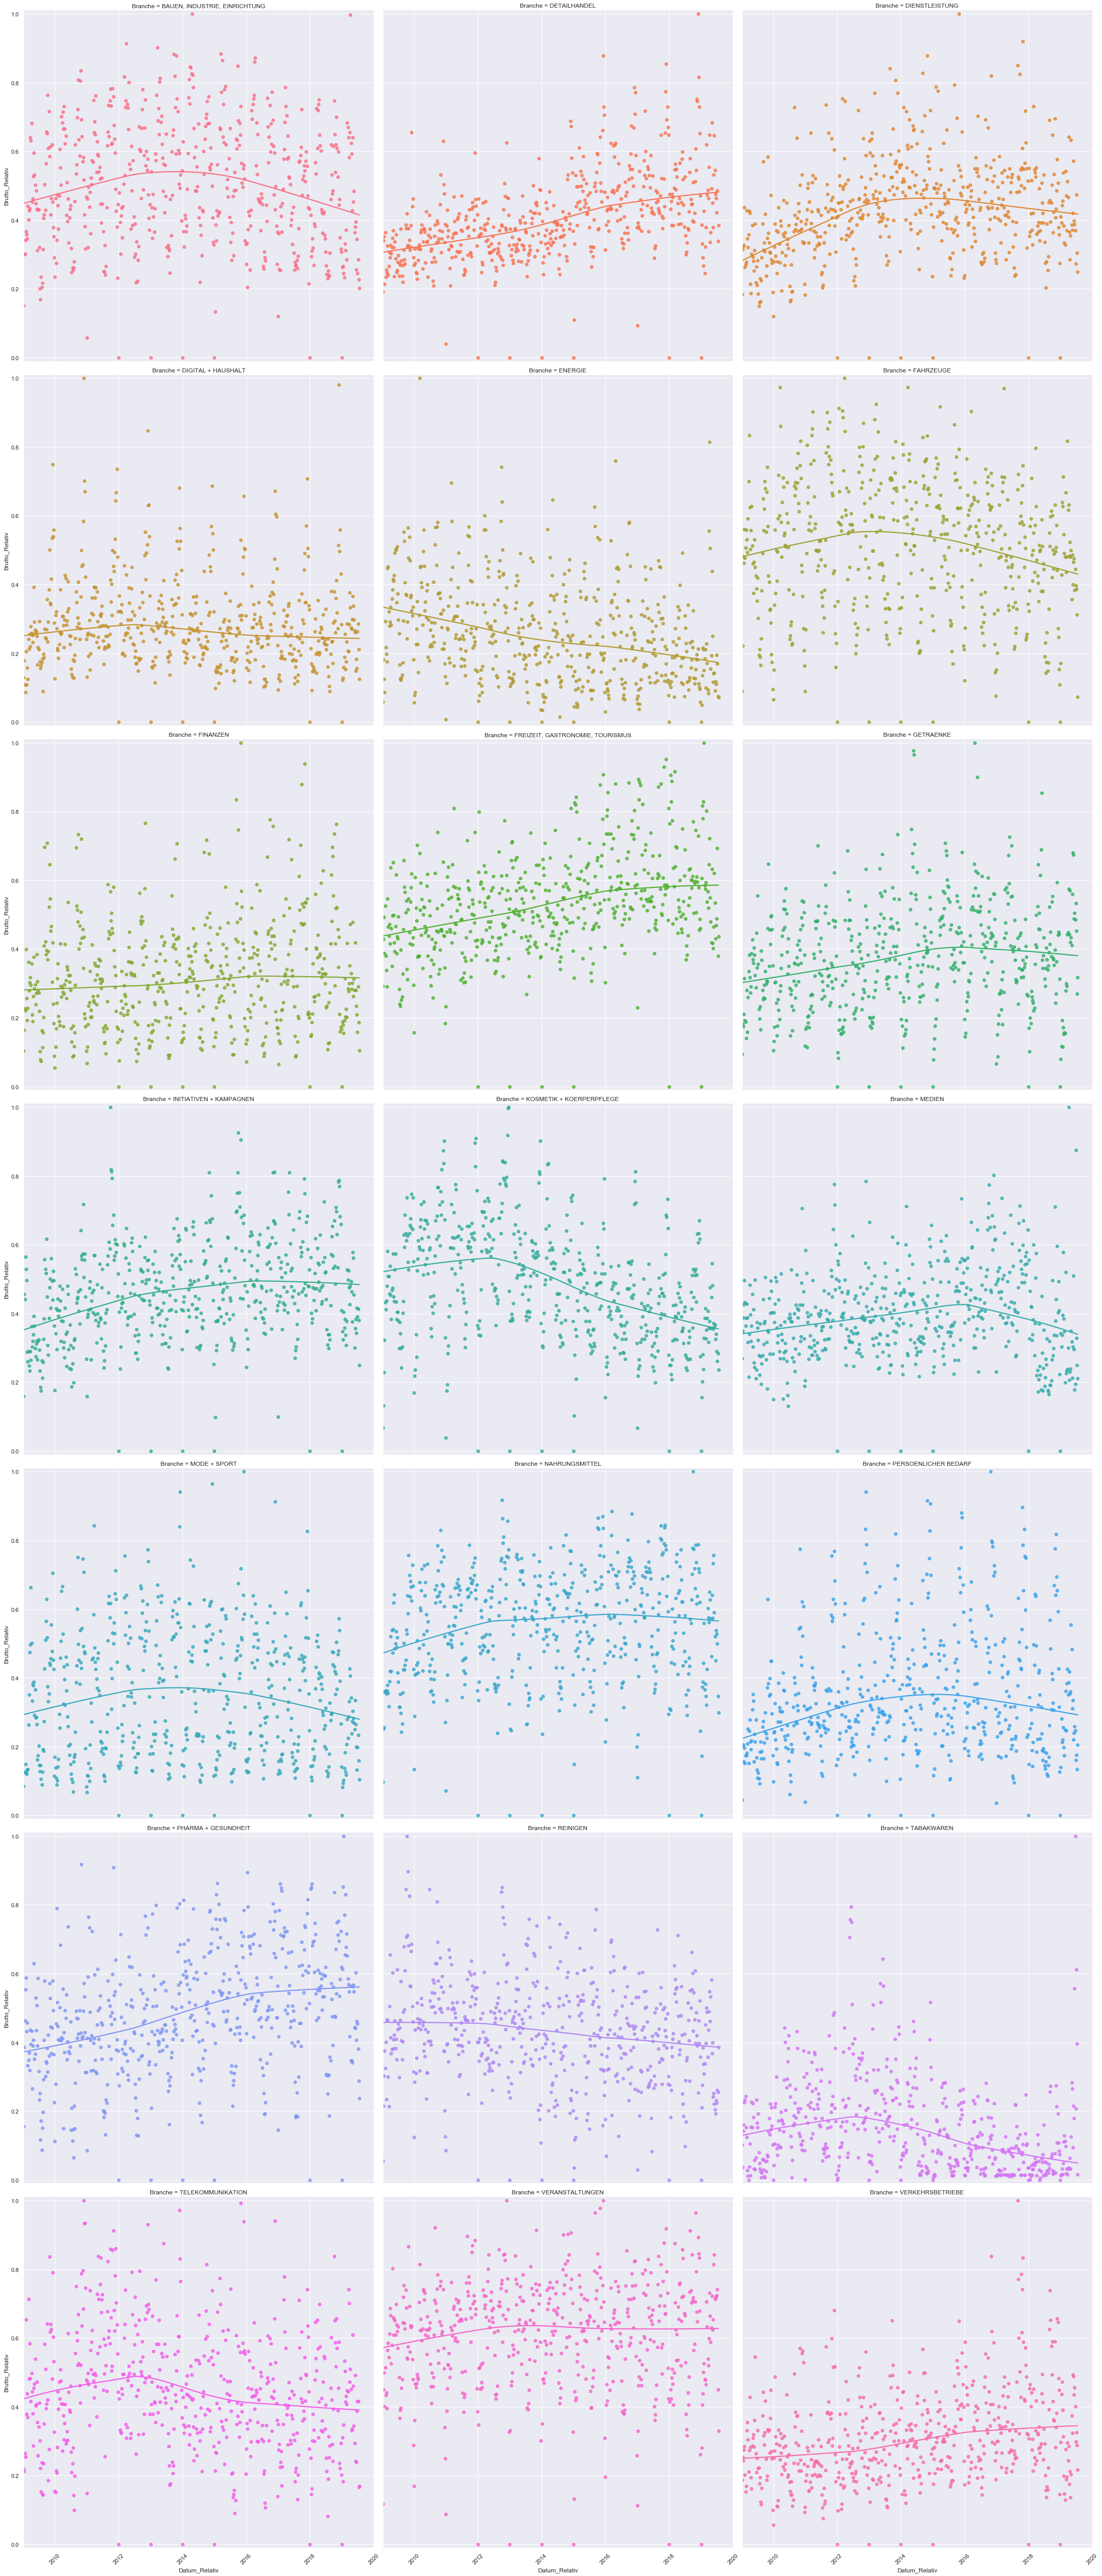

In [205]:
before_this_date = (br_kw_datum.Datum < iso_to_datetime(year=2019,kw=30,day=1))

g = sns.lmplot(
    x        = "Datum_Relativ",
    y        = "Brutto_Relativ",
    col      = "Branche",
    hue      = "Branche", # kinda useless, but nice to look at!
    data     = br_kw_datum.loc[before_this_date,:],
    col_wrap = 3, # How many plots per row
    height   = 10,
    #order    = 3, # polynomial regression of order, best for 1 or 2
    lowess  = True,
    #ci       = 95,
).set(
    xlim=(br_kw_datum.Datum_Relativ.min(), br_kw_datum.Datum_Relativ.max()),
    ylim=(br_kw_datum.Brutto_Relativ.min()-0.01, br_kw_datum.Brutto_Relativ.max()+0.01)
)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)


***
> 1. Regression is not good enough for fitting
2. Periodic effects (yearls, seasonal, holidays) are not taken into account. The plots look messy.
***

## `fbprophet`

- https://facebook.github.io/prophet/
- https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a

In [169]:
from fbprophet import (
    Prophet)

from fbprophet.plot import (
    add_changepoints_to_plot)

import holidays

CH_holidays = holidays.CH()



In [170]:
branchen_liste

['KOSMETIK + KOERPERPFLEGE',
 'FREIZEIT, GASTRONOMIE, TOURISMUS',
 'PERSOENLICHER BEDARF',
 'FAHRZEUGE',
 'ENERGIE',
 'TELEKOMMUNIKATION',
 'DIGITAL + HAUSHALT',
 'VERANSTALTUNGEN',
 'DETAILHANDEL',
 'FINANZEN',
 'MEDIEN',
 'DIENSTLEISTUNG',
 'NAHRUNGSMITTEL',
 'MODE + SPORT',
 'PHARMA + GESUNDHEIT',
 'GETRAENKE',
 'TABAKWAREN',
 'BAUEN, INDUSTRIE, EINRICHTUNG',
 'VERKEHRSBETRIEBE',
 'INITIATIVEN + KAMPAGNEN',
 'REINIGEN']

In [207]:
branchen_liste[16]

'TABAKWAREN'

In [211]:
%%time
################################################################################
## Prepare Dataset for Prophet:

branche_xyz = branchen_liste[16]
latest_date = iso_to_datetime(year=2019,kw=30, day=1)

print(f"Branche: {branche_xyz}")

select_branche = (br_kw_datum.Branche == branche_xyz)
before_maxdate = (br_kw_datum.Datum < latest_date)


df = (
    br_kw_datum
        .loc[select_branche & before_maxdate,["Datum","Brutto"]]
        .rename(columns={"Datum": "ds", "Brutto": "y"}) # Has to be "ds" and "y"
)

print(f"df.shape: {df.shape}")

################################################################################
## Define holidays (dataframe):

ch_holidays = (
    pd.DataFrame(
        holidays.CH(years = list(range(2005,2021))).items(),
        columns=["ds","holiday"]
    )
)

################################################################################
## Define Prophet's hyper variables:

m = Prophet(
        weekly_seasonality = False,
        daily_seasonality  = False,
        holidays           = ch_holidays,
)
# Fit/Train Prophet on dataset:
m.fit(df)

################################################################################
## Create dataset on which shall be predicted:

future = m.make_future_dataframe(
    periods         = 365,
    freq            = 'D',  # Frequency can be Days or Months 
    include_history = True  # Boolean

)

print(f"future.shape: {future.shape}")

# Let Prophet predict the future
forecast = m.predict(future)

################################################################################
print("forecast.tail()")
display(forecast.tail())

Branche: TABAKWAREN
df.shape: (559, 2)


C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



future.shape: (924, 1)
forecast.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Auffahrt,Auffahrt_lower,Auffahrt_upper,Karfreitag,Karfreitag_lower,Karfreitag_upper,Nationalfeiertag,Nationalfeiertag_lower,Nationalfeiertag_upper,Neujahrestag,Neujahrestag_lower,Neujahrestag_upper,Ostermontag,Ostermontag_lower,Ostermontag_upper,Ostern,Ostern_lower,Ostern_upper,Pfingsten,Pfingsten_lower,Pfingsten_upper,Pfingstmontag,Pfingstmontag_lower,Pfingstmontag_upper,Weihnachten,Weihnachten_lower,Weihnachten_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
919,2020-07-10,158728.159976,-93124.932786,356370.745167,148857.385575,168463.567289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-19025.568482,-19025.568482,-19025.568482,0.0,0.0,0.0,-19025.568482,-19025.568482,-19025.568482,0.0,0.0,0.0,139702.591493
920,2020-07-11,158746.137751,-80098.017569,366196.074687,148799.420346,168534.750338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25991.082837,-25991.082837,-25991.082837,0.0,0.0,0.0,-25991.082837,-25991.082837,-25991.082837,0.0,0.0,0.0,132755.054914
921,2020-07-12,158764.115527,-90821.409331,342859.023866,148758.008084,168557.656715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-32320.676743,-32320.676743,-32320.676743,0.0,0.0,0.0,-32320.676743,-32320.676743,-32320.676743,0.0,0.0,0.0,126443.438784
922,2020-07-13,158782.093303,-105660.426008,358273.650597,148728.367463,168639.147864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-38030.382982,-38030.382982,-38030.382982,0.0,0.0,0.0,-38030.382982,-38030.382982,-38030.382982,0.0,0.0,0.0,120751.710321
923,2020-07-14,158800.071079,-108494.046211,334584.853989,148711.174195,168663.008493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-43147.705066,-43147.705066,-43147.705066,0.0,0.0,0.0,-43147.705066,-43147.705066,-43147.705066,0.0,0.0,0.0,115652.366013


Wall time: 3.88 s


In [ ]:
"""
forecast
m
branche_xyz

"""

#################################################################################
Plot Components:


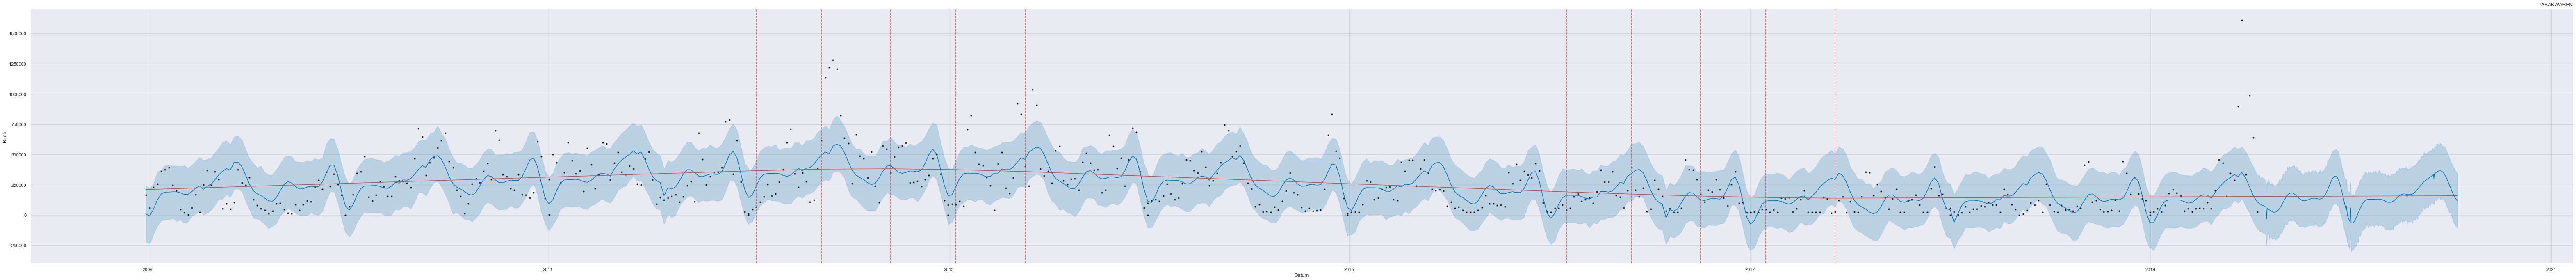

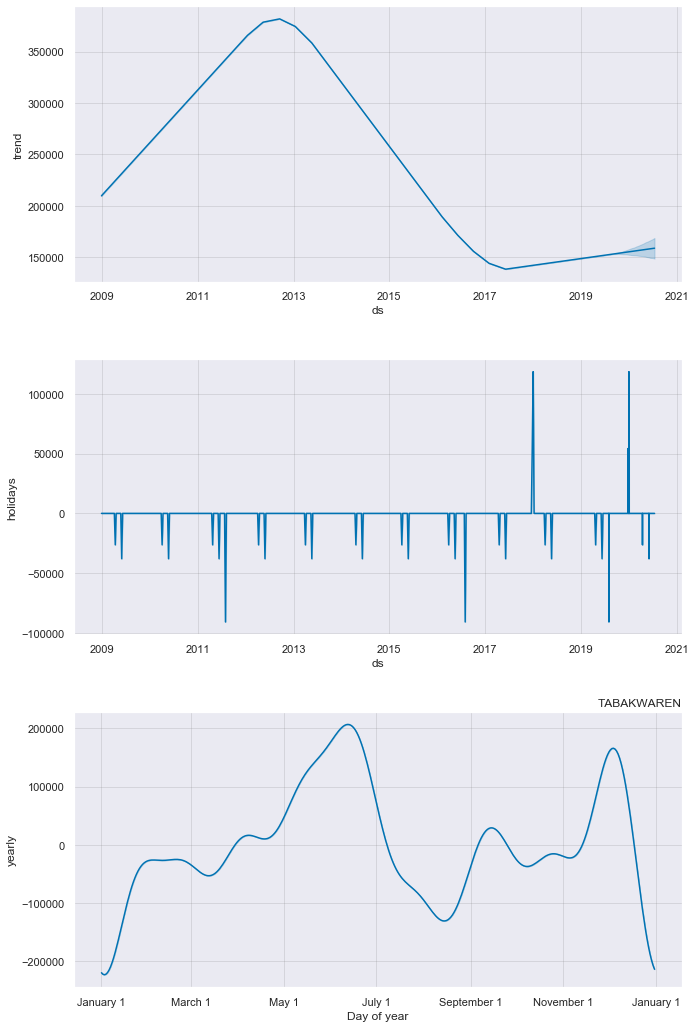

In [215]:
################################################################################
## Plot the known past as well the predicted future:
fig1 = (
    m.plot(
        forecast,
        xlabel = "Datum",
        ylabel = "Brutto",
    )
)

plt.title(branche_xyz, loc="right",)
fig1.set_size_inches(100,10)

# Plot underlying significant changepoints for trend computation
a = add_changepoints_to_plot(
    fig1.gca(),
    m,
    forecast)

################################################################################
## Plot Trend, holidays, yearly, weekly, whatever
print(81*"#")
print("Plot Components:")
fig2 = m.plot_components(forecast)
plt.title(branche_xyz, loc="right")

fig2.set_size_inches(10,15)



# Scribbles